In [1]:
# Connect goolge drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [120]:
# import libraries 
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler



# Preprocessing 



In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SF-Housing/afford_housing31.csv')
data.head()
data = data.iloc[:, 1:29]

In [4]:
data.head()

,ProjectID,ProjectName,Failing,Status,Street,ZipCode,SupervisorDistrict,ProjectArea,ProgramArea,ProjectType,HousingTenure,MarketRate,StudioUnits,OneBd,TwoBd,ThreeBd,FourBd,FiveBd,FamilyUnit,SeniorUnit,TAYUnit,HomelessUnit,DisabledUnit,LOSPUnit,PublicHousing,Proceed,daysProceed,ProjUnits
0,2006-002,Midtown Park Apartments,0.0,(1) Preliminary Phase,Scott,94115,5,0,Multifamily,Rehabilitation,Rental,0,0,24,55,60,0,0,139,0,0,0,0.0,0,0,2020-01-01,-384.0,139.0
1,2011-003,801 Brannan (Land Dedication Site),NaN,(1) Preliminary Phase,7th,94103,6,0,Multifamily,New Construction,Rental,1,0,0,0,0,0,0,149,0,0,0,0.0,0,0,NaN,NaN,150.0
2,2015-001,4th and Folsom,0.0,(1) Preliminary Phase,4th,94103,6,0,Multifamily,New Construction,Rental,1,0,0,0,0,0,0,84,0,0,9,0.0,0,0,2019-09-15,-492.0,85.0
3,2016-026,"HPSY, Block 1 (Hilltop)",1.0,(1) Preliminary Phase,Address not yet assigned,94124,10,0,Inclusionary-OCII,New Construction,Ownership,216,0,0,0,0,0,0,24,0,0,0,0.0,0,0,NaN,NaN,240.0
4,2016-057,101 Hyde,0.0,(1) Preliminary Phase,Hyde,94102,6,0,Multifamily,New Construction,Rental,1,0,0,0,0,0,0,84,0,0,0,0.0,0,0,NaN,NaN,85.0


In [5]:
# Select viable variables based on the situation. 
data = data.loc[:, ['Failing', 'Status', 'ZipCode', 'SupervisorDistrict', 
                    'ProgramArea', 'MarketRate', 'StudioUnits', 'OneBd', 
                    'TwoBd', 'daysProceed', 'ProjUnits']]
data.head()

,Failing,Status,ZipCode,SupervisorDistrict,ProgramArea,MarketRate,StudioUnits,OneBd,TwoBd,daysProceed,ProjUnits
0,0.0,(1) Preliminary Phase,94115,5,Multifamily,0,0,24,55,-384.0,139.0
1,NaN,(1) Preliminary Phase,94103,6,Multifamily,1,0,0,0,NaN,150.0
2,0.0,(1) Preliminary Phase,94103,6,Multifamily,1,0,0,0,-492.0,85.0
3,1.0,(1) Preliminary Phase,94124,10,Inclusionary-OCII,216,0,0,0,NaN,240.0
4,0.0,(1) Preliminary Phase,94102,6,Multifamily,1,0,0,0,NaN,85.0


In [6]:
# Make some variables to be categorical 
data.loc[:, 'Failing'].astype('category')
data.loc[:, 'ZipCode'].astype('category')
data.loc[:, 'SupervisorDistrict'].astype('category')

# Encode categorical string variables 
labelencoder = LabelEncoder()

data.loc[:, 'Status'] = labelencoder.fit_transform(data.loc[:, 'Status'])
data.loc[:, 'Status'].astype('category')
data.loc[:, 'ProgramArea'] = labelencoder.fit_transform(data.loc[:, 'ProgramArea'])
data.loc[:, 'ProgramArea'].astype('category')

data.head()




,Failing,Status,ZipCode,SupervisorDistrict,ProgramArea,MarketRate,StudioUnits,OneBd,TwoBd,daysProceed,ProjUnits
0,0.0,0,94115,5,4,0,0,24,55,-384.0,139.0
1,NaN,0,94103,6,4,1,0,0,0,NaN,150.0
2,0.0,0,94103,6,4,1,0,0,0,-492.0,85.0
3,1.0,0,94124,10,3,216,0,0,0,NaN,240.0
4,0.0,0,94102,6,4,1,0,0,0,NaN,85.0


In [7]:
# Get indices that has null values 
failing_null_ind = pd.isnull(data.loc[:, 'Failing'])
proceed_null_ind = pd.isnull(data.loc[:, 'daysProceed'])
units_null_ind = pd.isnull(data.loc[:, 'ProjUnits'])

# Replace na with np.nan
data.loc[failing_null_ind, 'Failing'] = np.NaN
data.loc[proceed_null_ind, 'daysProceed'] = np.NaN
data.loc[units_null_ind, 'ProjUnits'] = np.NaN


# Get indices that dose not have null values by features 
failing_notnull_ind = pd.notna(data.loc[:, 'Failing'])
proceed_notnull_ind = pd.notna(data.loc[:, 'daysProceed'])
units_notnull_ind = pd.notna(data.loc[:, 'ProjUnits'])

In [8]:
house_it = data

# Initiate models 
lm = LinearRegression()
glm = LogisticRegression()


In [9]:
data.describe()
data.isna().sum()

Failing                32
Status                  0
ZipCode                 0
SupervisorDistrict      0
ProgramArea             0
MarketRate              0
StudioUnits             0
OneBd                   0
TwoBd                   0
daysProceed           148
ProjUnits               8
dtype: int64

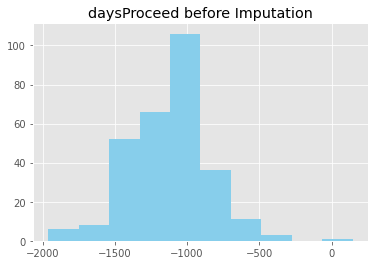

<function matplotlib.pyplot.show>

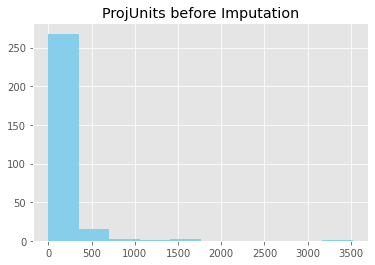

In [18]:
# Histogram of features before imputation
# daysProceed 
plt.hist(data.loc[:, 'daysProceed'], color = "skyblue")
plt.title("daysProceed before Imputation")
plt.show()

# ProjUnits
plt.hist(data.loc[:, 'ProjUnits'], color = "skyblue")
plt.title("ProjUnits before Imputation")
plt.show

In [11]:
# impute data with iterative regression. 
n_iter = 10

for i in range(n_iter):
  # Imputing Failing
  # Fit model Failing ~ Predictors 
  # Predictors with colinearity and NA values were excluded 
  m_failing = glm.fit(house_it.loc[failing_notnull_ind, ['Status', 'ProgramArea', 
                                                         'MarketRate', 'StudioUnits', 
                                                         'OneBd', 'TwoBd']], 
                      house_it.loc[failing_notnull_ind, 'Failing'])
  
  # Make Prediction with predictors with NA Failing Values 
  pred_failing = m_failing.predict(house_it.loc[failing_null_ind, ['Status', 
                                                                   'ProgramArea', 
                                                                   'MarketRate', 
                                                                   'StudioUnits', 
                                                                   'OneBd', 'TwoBd']])
  # Impute data with prediction
  house_it.loc[failing_null_ind, 'Failing'] = pred_failing

  # Fit model daysProceed ~ Predictors 
  # Predictors with colinearity and NA values were excluded 
  m_proceed = lm.fit(house_it.loc[proceed_notnull_ind, ['Failing', 'Status', 'ProgramArea', 
                                                         'MarketRate', 'StudioUnits', 
                                                         'OneBd', 'TwoBd']], 
                      house_it.loc[proceed_notnull_ind, 'daysProceed'])
  
  # Make Prediction with predictors with NA daysProceed Values 
  pred_proceed = m_proceed.predict(house_it.loc[proceed_null_ind, ['Failing','Status', 
                                                                   'ProgramArea', 
                                                                   'MarketRate', 
                                                                   'StudioUnits', 
                                                                   'OneBd', 'TwoBd']])
  # Impute data with prediction
  # Round up to natural number as day cannot be in decimal
  house_it.loc[proceed_null_ind, 'daysProceed'] = pred_proceed.round(0)

  # Fit model ProjUnits ~ Predictors 
  # Predictors with colinearity and NA values were excluded 
  m_units = lm.fit(house_it.loc[units_notnull_ind, ['Failing', 'Status', 'ProgramArea', 
                                                         'MarketRate', 'StudioUnits', 
                                                         'OneBd', 'TwoBd', 'daysProceed']], 
                      house_it.loc[units_notnull_ind, 'ProjUnits'])
  
  # Make Prediction with predictors with NA daysProceed Values 
  pred_units = m_units.predict(house_it.loc[units_null_ind, ['Failing','Status', 
                                                             'ProgramArea', 
                                                             'MarketRate', 
                                                             'StudioUnits', 
                                                             'OneBd', 'TwoBd', 
                                                             'daysProceed']])
  # Impute data with prediction
  # Round up to natural number as number of units cannot be in decimal. 
  house_it.loc[units_null_ind, 'ProjUnits'] = pred_units.round(0)



  



In [14]:
# Change data type of failing 
house_it.loc[:, 'Failing'].astype('int32')

# See if all NaN values were imputed. 
house_it.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Failing             289 non-null    float64
 1   Status              289 non-null    int64  
 2   ZipCode             289 non-null    int64  
 3   SupervisorDistrict  289 non-null    int64  
 4   ProgramArea         289 non-null    int64  
 5   MarketRate          289 non-null    int64  
 6   StudioUnits         289 non-null    int64  
 7   OneBd               289 non-null    int64  
 8   TwoBd               289 non-null    int64  
 9   daysProceed         289 non-null    float64
 10  ProjUnits           289 non-null    float64
dtypes: float64(3), int64(8)
memory usage: 25.0 KB


In [15]:
house_it.describe()

,Failing,Status,ZipCode,SupervisorDistrict,ProgramArea,MarketRate,StudioUnits,OneBd,TwoBd,daysProceed,ProjUnits
count,289.000000,289.00000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000
mean,0.622837,2.49481,94113.072664,6.844291,3.034602,94.152249,6.982699,9.820069,10.439446,-1132.515571,139.764706
std,0.485517,1.44607,11.935515,2.850434,1.563088,259.724876,20.928193,18.552351,23.853808,281.861829,273.997402
min,0.000000,0.00000,94102.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1960.000000,0.000000
25%,0.000000,1.00000,94103.000000,6.000000,2.000000,1.000000,0.000000,0.000000,0.000000,-1317.000000,33.000000
50%,1.000000,2.00000,94109.000000,6.000000,2.000000,19.000000,0.000000,2.000000,1.000000,-1090.000000,83.000000
75%,1.000000,4.00000,94124.000000,10.000000,4.000000,84.000000,3.000000,9.000000,6.000000,-982.000000,136.000000
max,1.000000,5.00000,94158.000000,11.000000,7.000000,3346.000000,226.000000,131.000000,201.000000,145.000000,3522.000000


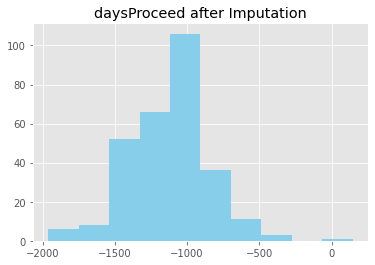

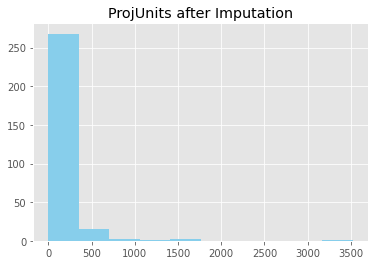

In [17]:
# Get histogram of a feature before and after the imputation 
# daysProceed after imputation
plt.hist(house_it.loc[:, 'daysProceed'], color = "skyblue")
plt.title("daysProceed after Imputation")
plt.show()

# ProjUnits 
plt.hist(house_it.loc[:, 'ProjUnits'], color = "skyblue")
plt.title("ProjUnits after Imputation")
plt.show()

In [19]:
# Predictors and features
x = house_it.iloc[:, 1:11]
y = house_it.loc[:, 'Failing']

# Normalization 
sc = StandardScaler()
x = sc.fit_transform(x)

# Train Test set split 
train, test = train_test_split(house_it, test_size = 0.3, random_state = 42)

# Response predictors split 
y_train = train.loc[:, 'Failing']
x_train = train.iloc[:, 1:11]

y_test = test.loc[:, 'Failing']
x_test = test.iloc[:, 1:11]

# Modeling 

## ROC Plot Function

In [118]:
# Define function to plot roc curve 
def roc_plot (y_test, y_prob, model_name):

  # Get false positive and true positive rate 
  fpr, tpr, threshold = roc_curve(y_test, y_prob[:, 1])

  # Plot size 
  plt.figure(figsize=(10,8))

  # Plot fpr, tpr 
  plt.plot([0,1], [0,1], 'k--')
  plt.plot(fpr, tpr)

  # Get AUC and show it on the plot
  plt.text(0.8, 0.15, "AUC: {}".format(round(roc_auc_score(y_test, y_prob[:, 1]), 3)))
  
  # x and y labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  
  # title 
  plt.title(model_name + " ROC Curve", fontweight = 'bold', fontsize = 15)
  plt.show()

## Importance Plot for Tree Based Models

In [119]:
# For tree based models
# Create feature importance plot
def plot_varimplot(importance, names, model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))

  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

  #Add chart labels
  plt.title(model_type + ' Feature Importance', fontweight = 'bold', fontsize = 15)
  plt.xlabel('Feature Importance')
  plt.ylabel('Feature Names')



## Elastic Net

### Parameter Selection

In [22]:
# Initialize model
glmnet = LogisticRegression(penalty = 'l1', solver = 'liblinear')
cv = RepeatedKFold(n_splits = 10, random_state = 1)

# Elastic Net Model 
grid = dict()
grid['C'] = np.arange(0, 1, 0.01)
search_glmnet = GridSearchCV(glmnet, grid, scoring = 'accuracy', cv = cv)

# Fit the model 
param_glmnet = search_glmnet.fit(x_train, y_train)

In [23]:
param_glmnet.best_params_

{'C': 0.11}

### Model Fitting & Performance Review

In [99]:
# Fit model with the most effective parameters
glmnet1 = LogisticRegression(penalty = 'l1', C = param_glmnet.best_params_["C"], solver = 'liblinear')

# Train the model
glmnet_1 = glmnet1.fit(x_train, y_train)

# Get training prediciton
glmnet_pred_train = glmnet_1.predict(x_train)

# Get test prediction 
glmnet_pred = glmnet_1.predict(x_test)

# Get test prediction probability
glmnet_prob = glmnet_1.predict_proba(x_test)

In [101]:
# Get training accuracy
glmnet_1_trkcv = accuracy_score(y_train, glmnet_pred_train, normalize = True)

In [81]:
# Get test accuracy 10-fold
glmnet_1_kcv = np.mean(cross_val_score(glmnet_1, x_test, y_test, cv = 10))
glmnet_1_kcv

0.9652777777777779

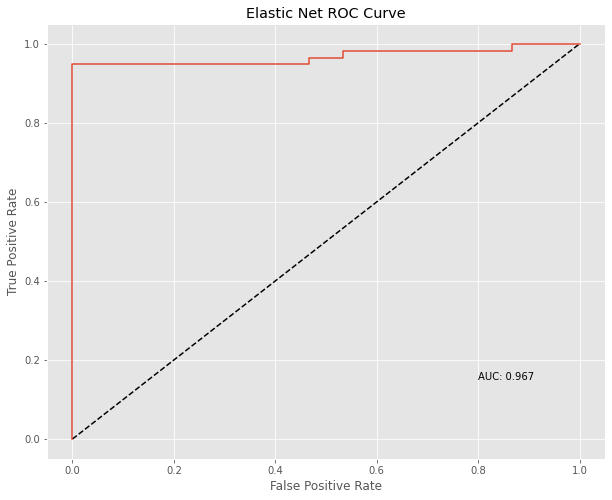

In [31]:
# Get ROC plot 
roc_plot(y_test, glmnet_prob, "Elastic Net")

## Random Forest

### Model Fitting & Performance Review

In [113]:
# Initialize rf model
rf = RandomForestClassifier(random_state = 42)

# Train Model 
rf1 = rf.fit(x_train, y_train)

# Get training/test prediciton, and test probability
rf1_pred_train = rf1.predict(x_train)
rf1_pred = rf1.predict(x_test)
rf1_prob = rf1.predict_proba(x_test)

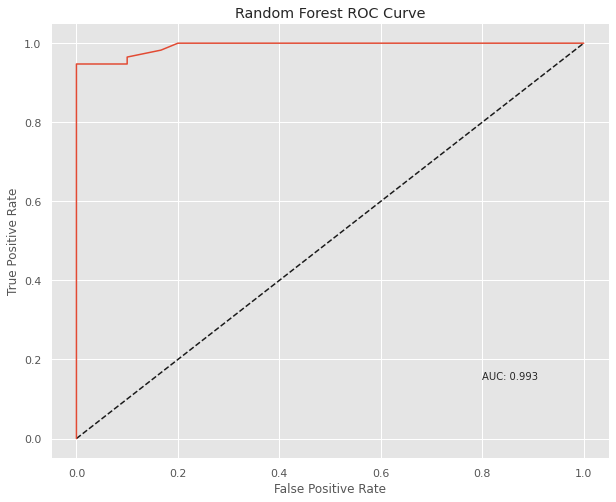

In [114]:
# Get ROC curve
roc_plot(y_test, rf1_prob, "Random Forest")

In [115]:
# Get training accuracy
rf1_kcv_train = accuracy_score(y_train, rf1_pred_train)
rf1_kcv_train

1.0

In [116]:
# Get test accuracy
rf1_kcv = np.mean(cross_val_score(rf1, x_test, y_test, cv = 10))
rf1_kcv

0.9652777777777779

### Importance Plot

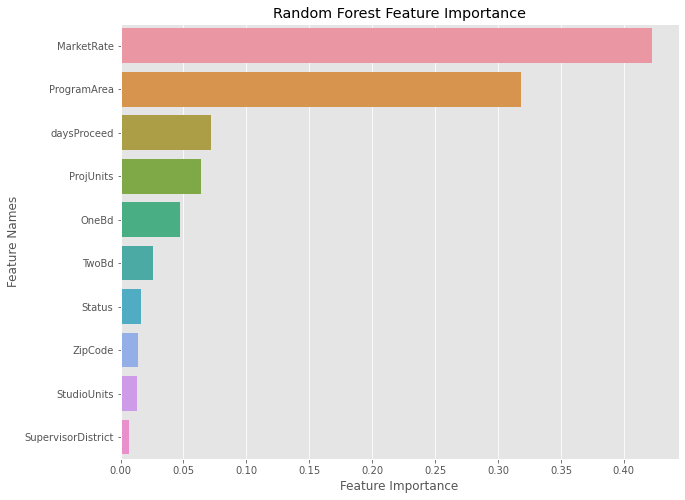

In [35]:
# Feature Importance 
plot_varimplot(rf1.feature_importances_, x_train.columns, 'Random Forest')

## Gradient Boosted Model

### Model Fitting & Performance Review

In [105]:
# Initialize GBM model 
gbm = GradientBoostingClassifier()

# Train model
gbm1 = gbm.fit(x_train, y_train)

# Get training/test prediciton, and test probability
gbm1_prob_train = gbm1.predict(x_train)
gbm1_pred = gbm1.predict(x_test)
gbm1_prob = gbm1.predict_proba(x_test)

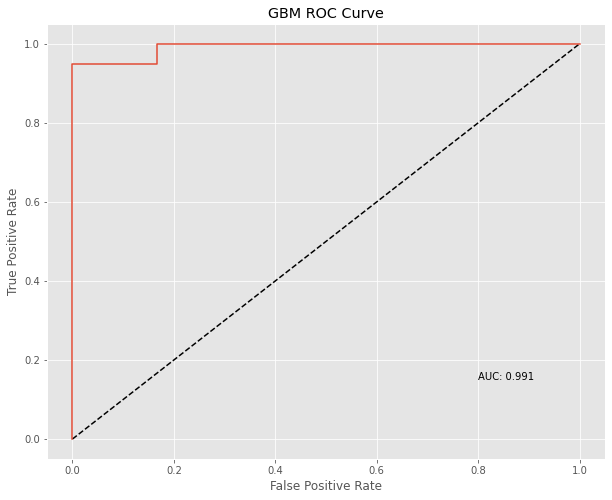

In [37]:
# Get ROC Curve
roc_plot(y_test, gbm1_prob, "GBM")

In [106]:
# Get training accuracy
gbm1_kcv_train = accuracy_score(y_train, gbm1_prob_train)
gbm1_kcv_train

1.0

In [83]:
# Get test accuracy
gbm1_kcv = np.mean(cross_val_score(gbm1, x_test, y_test, cv = 10))
gbm1_kcv 

0.9097222222222221

### Importance Plot

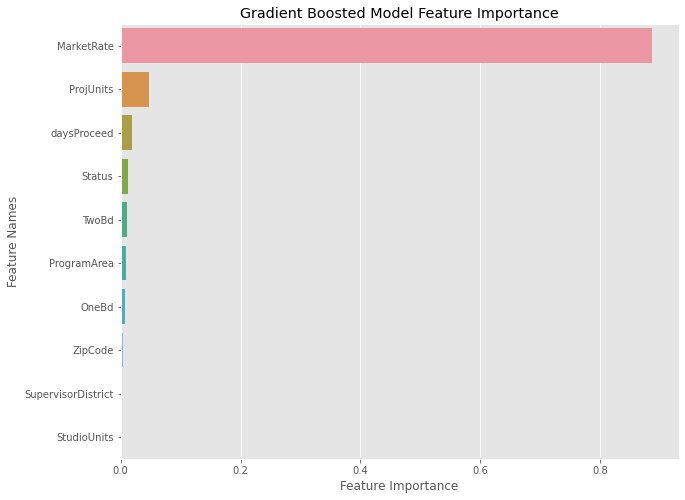

In [39]:
# Feature importance 
plot_varimplot(gbm1.feature_importances_, x_test.columns, 'Gradient Boosted Model')

## K-nearest Neighbors

### Parameter Selection

In [40]:
# Initialize KNN model 
knn = KNeighborsClassifier()

# Set parameters for gridsearch
leaf_size = list(range(1, 20))
n_neighbors = list(range(1, 10))
p = [1, 2]

# hypterparameter
hp = dict(leaf_size = leaf_size, n_neighbors = n_neighbors, p = p)

# gridsearch
knn_best = GridSearchCV(knn, hp, cv = 10)
knn_param = knn_best.fit(x_train, y_train)

# best parameter combination
knn_param.best_params_


{'leaf_size': 1, 'n_neighbors': 2, 'p': 1}

### Model Fitting & Performance Review

In [41]:
# Vanilla Model, no modification and parameters
knn1 = knn.fit(x_train, y_train)

# Get test prediction and its probabilities
knn1_pred = knn1.predict(x_test)
knn1_prob = knn1.predict_proba(x_test)

In [107]:
# With Selected Parameters 
knn2 = KNeighborsClassifier(leaf_size = knn_param.best_params_["leaf_size"], 
                            n_neighbors = knn_param.best_params_["n_neighbors"], 
                            p = knn_param.best_params_["p"])
# Train model
knn2_fit = knn2.fit(x_train, y_train)

# Get train/test prediction and its probabilities 
knn2_pred_train = knn2_fit.predict(x_train)
knn2_pred = knn2_fit.predict(x_test)
knn2_prob = knn2_fit.predict_proba(x_test)

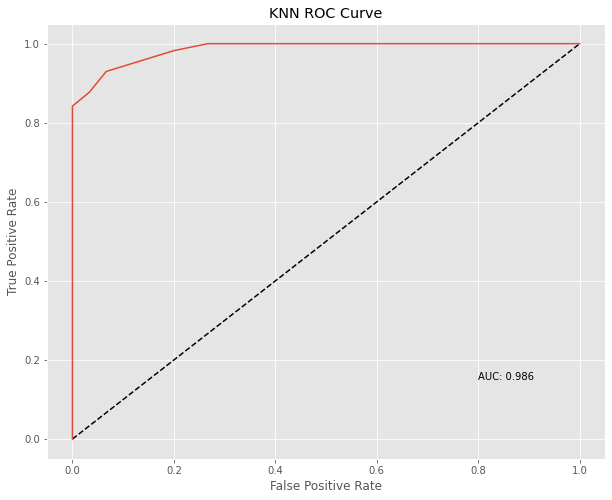

In [43]:
# Get ROC curve
roc_plot(y_test, knn1_prob, "KNN")

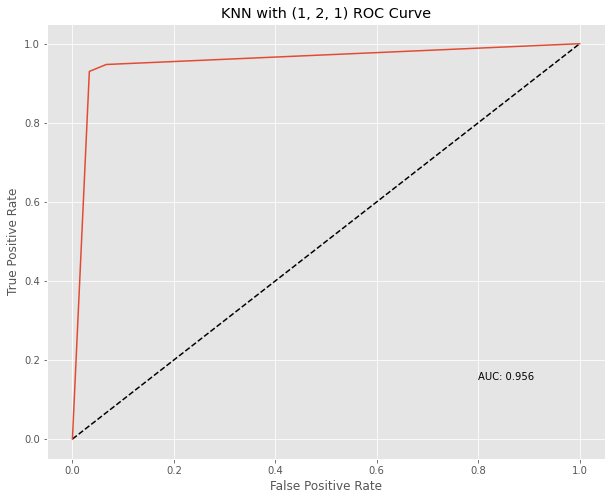

In [44]:
# Get ROC Curve with best parameters
roc_plot(y_test, knn2_prob, "KNN with (1, 2, 1)")

In [45]:
# test accuracy
knn1_kcv = np.mean(cross_val_score(knn1, x_test, y_test, cv = 10))
knn1_kcv

0.875

In [108]:
# train accuracy 
knn2_kcv_train = accuracy_score(y_train, knn2_pred_train)
knn2_kcv_train

0.9752475247524752

In [84]:
# test accuracy
knn2_kcv = np.mean(cross_val_score(knn2_fit, x_test, y_test, cv = 10))
knn2_kcv

0.9083333333333332

# Discriminant Analysis 

## Model Fitting & Performance Review (Linear)

In [109]:
# Initialize DA models 
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

# Linear 
lda1 = lda.fit(x_train, y_train)

# Get training prediction
lda1_pred_train = lda1.predict(x_train)

# Predict 
lda1_pred = lda1.predict(x_test)

# Predicted Probability
lda1_prob = lda1.predict_proba(x_test)

# Training accuracy
lda1_kcv_train = accuracy_score(y_train, lda1_pred_train)

# KCV 
lda1_kcv = np.mean(cross_val_score(lda1, x_test, y_test, cv = 10))
lda1_kcv

0.8638888888888889

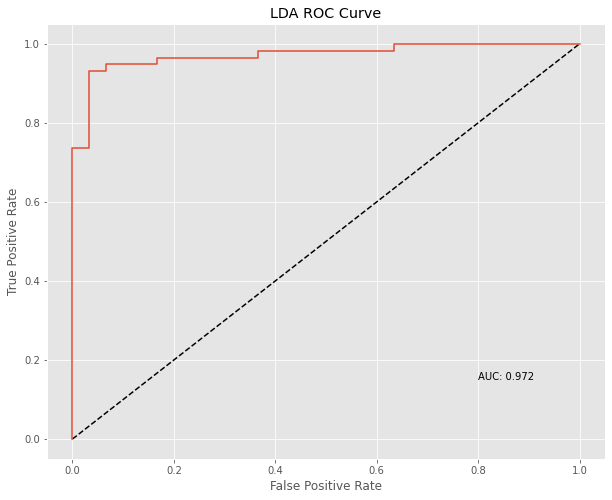

In [48]:
# Get ROC Plot
roc_plot(y_test, lda1_prob, "LDA")

## Model Fitting & Performance Review (Quadratic)

In [110]:
# train qda model
qda1 = qda.fit(x_train, y_train)

# get train prediction
qda1_pred_train = qda1.predict(x_train)

# get test prediction
qda1_pred = qda1.predict(x_test)

# get test prediction probabilities 
qda1_prob = qda1.predict_proba(x_test)

# Get train/test accuracy 
qda1_kcv_train = accuracy_score(y_train, qda1_pred_train)
qda1_kcv = np.mean(cross_val_score(qda1, x_test, y_test, cv = 10))
qda1_kcv

0.9541666666666666

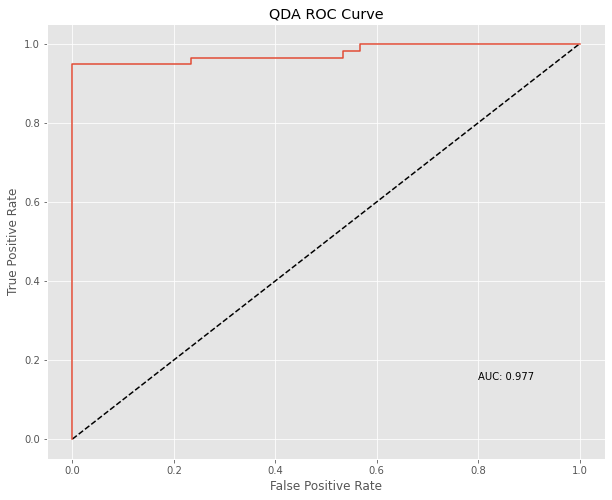

In [50]:
# get roc plot
roc_plot(y_test, qda1_prob, "QDA")

# Overall ROC Plot

In [111]:
# Get roc plots for every model. 

# Probabilites 
probas = [glmnet_prob[:, 1], 
          rf1_prob[:, 1],
          gbm1_prob[:, 1], 
          knn2_prob[:, 1], 
          lda1_prob[:, 1], 
          qda1_prob[:, 1]]

# Model Names 
classifiers = ['EN', 
               'RF', 
               'GBM',
               'KNN', 
               'LDA', 
               'QDA']
# Test accuracies 
kcv = [glmnet_1_kcv, 
       rf1_kcv, 
       gbm1_kcv, 
       knn2_kcv, 
       lda1_kcv, 
       qda1_kcv]

# Training accuracies 
tra = [glmnet_1_trkcv, 
       rf1_kcv_train, 
       gbm1_kcv_train, 
       knn2_kcv_train, 
       lda1_kcv_train, 
       qda1_kcv_train]

# Initialize result table 
result_table = pd.DataFrame(columns = ['fpr', 'tpr', 'auc'])

# For loop that creates dataframe with fpr, tpr, and auc. 
for p in range(0, len(probas)):
  y_proba = probas[p]

  fpr, tpr, _ = roc_curve(y_test, y_proba)
  auc = roc_auc_score(y_test, y_proba)

  result_table = result_table.append({'fpr': fpr, 
                                      'tpr': tpr, 
                                      'auc': auc}, ignore_index = True)

# add neccessary list on dataframe
result_table.insert(0, 'classifiers', classifiers)
result_table.insert(4, 'kcv', kcv)
result_table.insert(5, 'tra', tra)
result_table.set_index('classifiers', inplace = True)

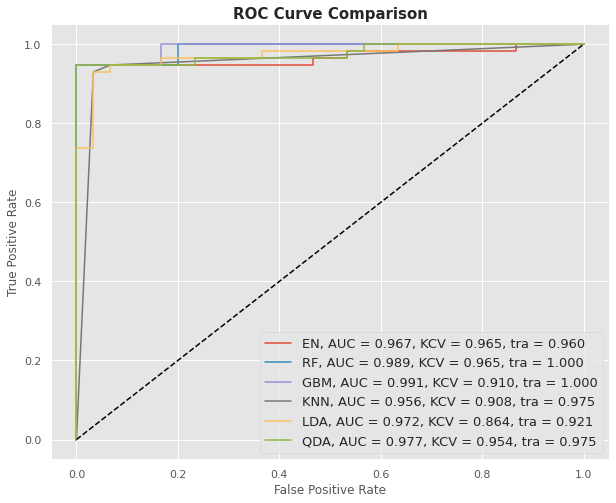

In [117]:
fig = plt.figure(figsize = (10, 8))

# For loop to plot every model's roc.
for i in result_table.index: 
  plt.plot(result_table.loc[i]['fpr'], 
           result_table.loc[i]['tpr'], 
           # Legend (model name, auc, test accuracy, training accuracy)
           label = "{}, AUC = {:.3f}, KCV = {:.3f}, tra = {:.3f}".format(i, 
                                                           result_table.loc[i]['auc'], 
                                                           result_table.loc[i]['kcv'], 
                                                           result_table.loc[i]['tra']))

# Dotted line abline(0, 1)
plt.plot([0,1], [0,1], color = 'black', linestyle = '--')

# x axis label and ticks
plt.xticks(np.arange(0.0, 1.2, step = 0.2))
plt.xlabel("False Positive Rate")

# y axis label and ticks
plt.yticks(np.arange(0.0, 1.2, step = 0.2))
plt.ylabel("True Positive Rate")

# title
plt.title('ROC Curve Comparison', fontweight = 'bold', fontsize = 15)
plt.legend(prop = {'size': 13}, loc = 'lower right')

plt.show()

Overall, either random forest or elastic net seems to be the best options for analyzing and classification with this dataset. 